In [ ]:
import torch
from torch import nn

# SRGAN Architecture Implementation

In [ ]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        discriminator=False,
        use_act=True,
        use_bn=True,
        **kwargs,
    ):
        super().__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
            if discriminator
            else nn.PReLU(num_parameters=out_channels)
        )

    def forward(self, x):
        return self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))


In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False,
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x


In [ ]:
class SR_Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_channels, 2), UpsampleBlock(num_channels, 2))
        # self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)
        self.final = nn.Conv2d(num_channels, 3, kernel_size=9, stride=1, padding=4)


    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = self.convblock(x) + initial
        x = self.upsamples(x)
        return torch.tanh(self.final(x))

In [ ]:

class SR_Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    discriminator=True,
                    use_act=True,
                    use_bn=False if idx == 0 else True,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

In [ ]:
 def test():
   low_resolution = 9 #96x96 => 24x24
   x = torch.randn(100,3,low_resolution,low_resolution)
   gen = Generator()
   gen_out = gen(x)
   disc = Discriminator()
   disc_out = disc(gen_out)

   print(gen_out.shape)
   print(disc_out.shape)
test()

NameError: ignored

In [ ]:
!pip3 install transformers
!pip3 install sentencepiece

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 636 kB 45.9 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 895 kB 40.6 MB/s 
     |████████████████████████████████| 3.3 MB 35.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import os
 
%matplotlib inline

In [ ]:
os.listdir("/content/drive/MyDrive/Datasets/MIN_DATASET/")

['tamil_text_descriptions.npy',
 'Txt',
 'Generated',
 'Image',
 'model',
 'Generated1',
 'SRGenerated']

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 5
STATS = (.5, .5, .5), (.5, .5, .5)
DATA_DIR = '/content/drive/MyDrive/Datasets/MIN_DATASET/Image'

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform= T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize((.5, .5, .5), (.5, .5, .5))
]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

In [ ]:
img, _ = next(iter(train_dl))
img.shape

torch.Size([5, 3, 64, 64])

In [ ]:
def denorm(img_tensor):
    return img_tensor * STATS[1][0] + STATS[0][0]

In [ ]:
def showImages(images):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach())).permute(1, 2, 0))

def showBatch(dl):
    for images, _ in dl:
        showImages(images)
        break

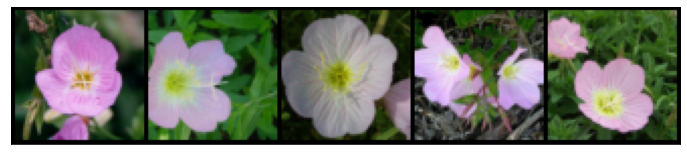

In [ ]:
showBatch(train_dl)

In [ ]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:

class TextToLatent:
    def __init__(self, bertModel='ai4bharat/indic-bert') -> None:
        self.tokenizer = AutoTokenizer.from_pretrained(bertModel)
        self.model = AutoModel.from_pretrained(bertModel)
    
    def convert_text_to_latent(self, inp_texts, latent_size = 100):
        self.token_tensor = self.tokenizer(inp_texts, padding=True, truncation=True, return_tensors='pt').input_ids

        self.model.eval()

        with torch.no_grad():
            outputs = self.model(self.token_tensor)
            hidden_state = outputs.last_hidden_state
            # hidden_state shape: torch.Size([BATCH_SIZE, TOKEN_DIMS, 768])
        
        hidden_state = hidden_state.view(hidden_state.shape[0], -1)
        # hidden_state shape: torch.Size([BATCH_SIZE, TOKEN_DIMS * 768])

        latent_layer_model = torch.nn.Linear(hidden_state.shape[1], latent_size)
        # latent_layer_model shape: torch.Size([TOKEN_DIMS * 768, LATENT_SIZE])

        latent_layer = latent_layer_model(hidden_state)
        # latent_layer shape: torch.Size([BATCH_SIZE, LATENT_SIZE])

        latent_layer = latent_layer.view(latent_layer.shape[0], latent_size, 1, 1)
        # latent_layer shape: torch.Size([BATCH_SIZE, LATENT_SIZE, 1, 1])

        return latent_layer

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
class TextDataset(TextToLatent):
  def __init__(self, text_path):
    self.tamil_text = np.load(text_path).tolist()
    self.final_arr = []
    self.lv = []
    super().__init__()

  def makeBatches(self, batch_size=5):
    for i in range(0, len(self.tamil_text), batch_size):
      self.final_arr.append(self.tamil_text[i:i+batch_size])
    return self.final_arr
  
  def convert_latents_to_batches(self):
    for batch in tqdm(self.makeBatches()):
      self.lv.append(self.convert_text_to_latent(inp_texts=batch))
    return self.lv


In [ ]:
text_dataset = TextDataset('/content/drive/MyDrive/Datasets/MIN_DATASET/tamil_text_descriptions.npy')
latent_vectors_batched = text_dataset.convert_latents_to_batches()
print(latent_vectors_batched[0].shape)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/8 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([5, 100, 1, 1])


In [ ]:
latent_vectors_batched[0].device

device(type='cpu')

In [ ]:
base_discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
    nn.Conv2d(512, 1,  kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(base_discriminator, device)

In [ ]:
base_generator  = nn.Sequential(
    # in: LATENT_SIZE x 1 x 1
    nn.ConvTranspose2d(latent_vectors_batched[0].shape[1], 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
generator = to_device(base_generator, device)

In [ ]:
latent_vectors_batched = [to_device(lvb, device) for lvb in latent_vectors_batched]
print(latent_vectors_batched[1].device)

cuda:0


In [ ]:
import torch.optim as optim

In [ ]:
def train_discriminator(real_image, gen_input, opt_d):
  opt_d.zero_grad()

  #Pass real Image through discriminator
  real_preds = discriminator(real_image)
  real_targets = torch.ones(real_image.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #Generate fake images from text description
  fake_images = generator(gen_input)

  #Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward(retain_graph=True)
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(gen_input, opt_g):
  opt_g.zero_grad()

  #Generate fake images from text description
  fake_images = generator(gen_input)

  #Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(gen_input.size(0), 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  #Update generator weights
  loss.backward(retain_graph=True)
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = '/content/drive/MyDrive/Datasets/MIN_DATASET/Generated/Images'
os.makedirs(sample_dir, exist_ok = True)

In [ ]:
sr_dir = '/content/drive/MyDrive/Datasets/MIN_DATASET/SRGenerated/Images'
os.makedirs(sr_dir, exist_ok = True)

In [ ]:
def save_sample(index, gen_input, show=True):
    fake_images = generator(gen_input)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname))
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize = (12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()).permute(1, 2, 0))

In [ ]:
def save_sample2(index, gen_input, show=True):
    fake_images = srgenerator(gen_input)
    fake_fname = 'srgenerated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sr_dir, fake_fname))
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize = (12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()).permute(1, 2, 0))

Saving srgenerated-images-0000.png


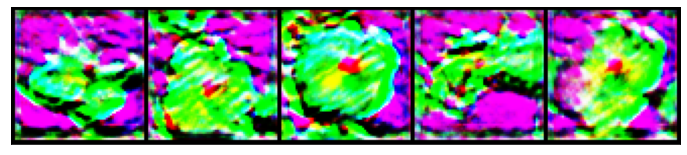

In [ ]:
save_sample2(0, generator(latent_vectors_batched[0]))

In [ ]:
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    #Losses and Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for i, (real_images, _) in tqdm(enumerate(train_dl)):
            # Train discriminator 

            loss_d, real_score, fake_score = train_discriminator(real_image=real_images, gen_input=latent_vectors_batched[i] , opt_d=opt_d)
            loss_g = train_generator(gen_input=latent_vectors_batched[i], opt_g=opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save Generated images
        save_sample(epoch+start_idx, latent_vectors_batched[i], show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 400

In [ ]:
history = fit(epochs, lr)

0it [00:00, ?it/s]

Epoch [1/400], loss_g: 6.0130, loss_d: 0.1229, real_score: 0.9680, fake_score: 0.0848
Saving generated-images-0001.png


0it [00:00, ?it/s]

Epoch [2/400], loss_g: 7.2735, loss_d: 0.1997, real_score: 0.8435, fake_score: 0.0049
Saving generated-images-0002.png


0it [00:00, ?it/s]

Epoch [3/400], loss_g: 11.5159, loss_d: 0.1031, real_score: 0.9073, fake_score: 0.0000
Saving generated-images-0003.png


0it [00:00, ?it/s]

Epoch [4/400], loss_g: 11.3190, loss_d: 0.6794, real_score: 0.9957, fake_score: 0.4102
Saving generated-images-0004.png


0it [00:00, ?it/s]

Epoch [5/400], loss_g: 5.1198, loss_d: 0.0332, real_score: 0.9789, fake_score: 0.0115
Saving generated-images-0005.png


0it [00:00, ?it/s]

Epoch [6/400], loss_g: 6.4582, loss_d: 0.1350, real_score: 0.8842, fake_score: 0.0062
Saving generated-images-0006.png


0it [00:00, ?it/s]

Epoch [7/400], loss_g: 5.0981, loss_d: 0.0831, real_score: 0.9875, fake_score: 0.0668
Saving generated-images-0007.png


0it [00:00, ?it/s]

Epoch [8/400], loss_g: 13.2435, loss_d: 0.1996, real_score: 0.8308, fake_score: 0.0000
Saving generated-images-0008.png


0it [00:00, ?it/s]

Epoch [9/400], loss_g: 5.3332, loss_d: 0.0202, real_score: 0.9933, fake_score: 0.0134
Saving generated-images-0009.png


0it [00:00, ?it/s]

Epoch [10/400], loss_g: 10.6899, loss_d: 0.0385, real_score: 0.9628, fake_score: 0.0001
Saving generated-images-0010.png


0it [00:00, ?it/s]

Epoch [11/400], loss_g: 10.4441, loss_d: 0.0098, real_score: 0.9903, fake_score: 0.0001
Saving generated-images-0011.png


0it [00:00, ?it/s]

Epoch [12/400], loss_g: 5.3382, loss_d: 0.0377, real_score: 0.9714, fake_score: 0.0083
Saving generated-images-0012.png


0it [00:00, ?it/s]

Epoch [13/400], loss_g: 8.7835, loss_d: 0.1143, real_score: 0.9580, fake_score: 0.0679
Saving generated-images-0013.png


0it [00:00, ?it/s]

Epoch [14/400], loss_g: 5.1491, loss_d: 0.0367, real_score: 0.9828, fake_score: 0.0190
Saving generated-images-0014.png


0it [00:00, ?it/s]

Epoch [15/400], loss_g: 9.2246, loss_d: 0.0151, real_score: 0.9853, fake_score: 0.0002
Saving generated-images-0015.png


0it [00:00, ?it/s]

Epoch [16/400], loss_g: 6.4772, loss_d: 0.0916, real_score: 0.9671, fake_score: 0.0557
Saving generated-images-0016.png


0it [00:00, ?it/s]

Epoch [17/400], loss_g: 6.9845, loss_d: 0.0782, real_score: 0.9446, fake_score: 0.0202
Saving generated-images-0017.png


0it [00:00, ?it/s]

Epoch [18/400], loss_g: 7.5397, loss_d: 0.0636, real_score: 0.9708, fake_score: 0.0332
Saving generated-images-0018.png


0it [00:00, ?it/s]

Epoch [19/400], loss_g: 7.6260, loss_d: 0.0514, real_score: 0.9750, fake_score: 0.0257
Saving generated-images-0019.png


0it [00:00, ?it/s]

Epoch [20/400], loss_g: 6.8316, loss_d: 0.0599, real_score: 0.9438, fake_score: 0.0018
Saving generated-images-0020.png


0it [00:00, ?it/s]

Epoch [21/400], loss_g: 16.3534, loss_d: 10.6006, real_score: 0.0002, fake_score: 0.0000
Saving generated-images-0021.png


0it [00:00, ?it/s]

Epoch [22/400], loss_g: 5.9222, loss_d: 0.2051, real_score: 0.9738, fake_score: 0.1622
Saving generated-images-0022.png


0it [00:00, ?it/s]

Epoch [23/400], loss_g: 13.3190, loss_d: 0.8596, real_score: 0.9677, fake_score: 0.5576
Saving generated-images-0023.png


0it [00:00, ?it/s]

Epoch [24/400], loss_g: 3.9230, loss_d: 0.1883, real_score: 0.8774, fake_score: 0.0485
Saving generated-images-0024.png


0it [00:00, ?it/s]

Epoch [25/400], loss_g: 7.0341, loss_d: 0.7744, real_score: 0.6216, fake_score: 0.0029
Saving generated-images-0025.png


0it [00:00, ?it/s]

Epoch [26/400], loss_g: 5.5833, loss_d: 0.2454, real_score: 0.9456, fake_score: 0.1657
Saving generated-images-0026.png


0it [00:00, ?it/s]

Epoch [27/400], loss_g: 3.9016, loss_d: 0.2009, real_score: 0.8959, fake_score: 0.0817
Saving generated-images-0027.png


0it [00:00, ?it/s]

Epoch [28/400], loss_g: 3.9837, loss_d: 1.1654, real_score: 0.5223, fake_score: 0.0088
Saving generated-images-0028.png


0it [00:00, ?it/s]

Epoch [29/400], loss_g: 4.1410, loss_d: 0.1305, real_score: 0.9539, fake_score: 0.0787
Saving generated-images-0029.png


0it [00:00, ?it/s]

Epoch [30/400], loss_g: 0.0421, loss_d: 1.0125, real_score: 0.4469, fake_score: 0.0100
Saving generated-images-0030.png


0it [00:00, ?it/s]

Epoch [31/400], loss_g: 4.8143, loss_d: 0.0800, real_score: 0.9608, fake_score: 0.0383
Saving generated-images-0031.png


0it [00:00, ?it/s]

Epoch [32/400], loss_g: 2.0149, loss_d: 1.4248, real_score: 0.4583, fake_score: 0.0033
Saving generated-images-0032.png


0it [00:00, ?it/s]

Epoch [33/400], loss_g: 4.5944, loss_d: 0.3430, real_score: 0.9359, fake_score: 0.2283
Saving generated-images-0033.png


0it [00:00, ?it/s]

Epoch [34/400], loss_g: 2.4206, loss_d: 0.9352, real_score: 0.4928, fake_score: 0.0070
Saving generated-images-0034.png


0it [00:00, ?it/s]

Epoch [35/400], loss_g: 4.4192, loss_d: 0.2508, real_score: 0.9752, fake_score: 0.1973
Saving generated-images-0035.png


0it [00:00, ?it/s]

Epoch [36/400], loss_g: 5.9452, loss_d: 0.9024, real_score: 0.5890, fake_score: 0.0009
Saving generated-images-0036.png


0it [00:00, ?it/s]

Epoch [37/400], loss_g: 5.1476, loss_d: 0.9298, real_score: 0.5973, fake_score: 0.0149
Saving generated-images-0037.png


0it [00:00, ?it/s]

Epoch [38/400], loss_g: 8.6556, loss_d: 1.4235, real_score: 0.9934, fake_score: 0.7167
Saving generated-images-0038.png


0it [00:00, ?it/s]

Epoch [39/400], loss_g: 6.6229, loss_d: 0.3877, real_score: 0.7516, fake_score: 0.0050
Saving generated-images-0039.png


0it [00:00, ?it/s]

Epoch [40/400], loss_g: 2.5604, loss_d: 0.3210, real_score: 0.7399, fake_score: 0.0042
Saving generated-images-0040.png


0it [00:00, ?it/s]

Epoch [41/400], loss_g: 2.7570, loss_d: 0.2794, real_score: 0.8419, fake_score: 0.0887
Saving generated-images-0041.png


0it [00:00, ?it/s]

Epoch [42/400], loss_g: 5.3680, loss_d: 0.1408, real_score: 0.9208, fake_score: 0.0542
Saving generated-images-0042.png


0it [00:00, ?it/s]

Epoch [43/400], loss_g: 5.1554, loss_d: 0.5157, real_score: 0.8160, fake_score: 0.2306
Saving generated-images-0043.png


0it [00:00, ?it/s]

Epoch [44/400], loss_g: 5.1599, loss_d: 0.2938, real_score: 0.8268, fake_score: 0.0833
Saving generated-images-0044.png


0it [00:00, ?it/s]

Epoch [45/400], loss_g: 4.4581, loss_d: 0.2556, real_score: 0.7901, fake_score: 0.0150
Saving generated-images-0045.png


0it [00:00, ?it/s]

Epoch [46/400], loss_g: 10.1564, loss_d: 4.4417, real_score: 0.0727, fake_score: 0.0000
Saving generated-images-0046.png


0it [00:00, ?it/s]

Epoch [47/400], loss_g: 3.8299, loss_d: 0.0526, real_score: 0.9895, fake_score: 0.0404
Saving generated-images-0047.png


0it [00:00, ?it/s]

Epoch [48/400], loss_g: 3.3192, loss_d: 0.3502, real_score: 0.7774, fake_score: 0.0685
Saving generated-images-0048.png


0it [00:00, ?it/s]

Epoch [49/400], loss_g: 5.1351, loss_d: 0.1782, real_score: 0.9799, fake_score: 0.1359
Saving generated-images-0049.png


0it [00:00, ?it/s]

Epoch [50/400], loss_g: 6.8462, loss_d: 0.3026, real_score: 0.9621, fake_score: 0.2217
Saving generated-images-0050.png


0it [00:00, ?it/s]

Epoch [51/400], loss_g: 8.2671, loss_d: 0.9875, real_score: 0.5602, fake_score: 0.0001
Saving generated-images-0051.png


0it [00:00, ?it/s]

Epoch [52/400], loss_g: 2.5530, loss_d: 0.8804, real_score: 0.7721, fake_score: 0.3176
Saving generated-images-0052.png


0it [00:00, ?it/s]

Epoch [53/400], loss_g: 3.8953, loss_d: 0.1618, real_score: 0.8735, fake_score: 0.0194
Saving generated-images-0053.png


0it [00:00, ?it/s]

Epoch [54/400], loss_g: 3.6916, loss_d: 0.2132, real_score: 0.9321, fake_score: 0.1323
Saving generated-images-0054.png


0it [00:00, ?it/s]

Epoch [55/400], loss_g: 2.7210, loss_d: 0.5829, real_score: 0.6211, fake_score: 0.0131
Saving generated-images-0055.png


0it [00:00, ?it/s]

Epoch [56/400], loss_g: 6.3102, loss_d: 0.3036, real_score: 0.9819, fake_score: 0.2294
Saving generated-images-0056.png


0it [00:00, ?it/s]

Epoch [57/400], loss_g: 3.6881, loss_d: 0.6018, real_score: 0.5949, fake_score: 0.0216
Saving generated-images-0057.png


0it [00:00, ?it/s]

Epoch [58/400], loss_g: 3.6775, loss_d: 0.1799, real_score: 0.9772, fake_score: 0.1425
Saving generated-images-0058.png


0it [00:00, ?it/s]

Epoch [59/400], loss_g: 2.8105, loss_d: 0.3503, real_score: 0.7627, fake_score: 0.0526
Saving generated-images-0059.png


0it [00:00, ?it/s]

Epoch [60/400], loss_g: 4.0082, loss_d: 0.1309, real_score: 0.9846, fake_score: 0.1060
Saving generated-images-0060.png


0it [00:00, ?it/s]

Epoch [61/400], loss_g: 4.7894, loss_d: 0.2538, real_score: 0.9165, fake_score: 0.1350
Saving generated-images-0061.png


0it [00:00, ?it/s]

Epoch [62/400], loss_g: 2.7722, loss_d: 0.4370, real_score: 0.7785, fake_score: 0.1173
Saving generated-images-0062.png


0it [00:00, ?it/s]

Epoch [63/400], loss_g: 1.9162, loss_d: 0.3874, real_score: 0.7288, fake_score: 0.0415
Saving generated-images-0063.png


0it [00:00, ?it/s]

Epoch [64/400], loss_g: 6.2304, loss_d: 0.2721, real_score: 0.9576, fake_score: 0.1846
Saving generated-images-0064.png


0it [00:00, ?it/s]

Epoch [65/400], loss_g: 5.1701, loss_d: 0.0710, real_score: 0.9416, fake_score: 0.0092
Saving generated-images-0065.png


0it [00:00, ?it/s]

Epoch [66/400], loss_g: 4.4072, loss_d: 0.1325, real_score: 0.9503, fake_score: 0.0763
Saving generated-images-0066.png


0it [00:00, ?it/s]

Epoch [67/400], loss_g: 5.5225, loss_d: 0.0904, real_score: 0.9547, fake_score: 0.0418
Saving generated-images-0067.png


0it [00:00, ?it/s]

Epoch [68/400], loss_g: 9.0532, loss_d: 0.7399, real_score: 0.9659, fake_score: 0.4542
Saving generated-images-0068.png


0it [00:00, ?it/s]

Epoch [69/400], loss_g: 4.4308, loss_d: 0.4129, real_score: 0.8360, fake_score: 0.1449
Saving generated-images-0069.png


0it [00:00, ?it/s]

Epoch [70/400], loss_g: 6.4484, loss_d: 0.1952, real_score: 0.8944, fake_score: 0.0675
Saving generated-images-0070.png


0it [00:00, ?it/s]

Epoch [71/400], loss_g: 3.2105, loss_d: 0.6379, real_score: 0.7505, fake_score: 0.1388
Saving generated-images-0071.png


0it [00:00, ?it/s]

Epoch [72/400], loss_g: 4.9830, loss_d: 0.5359, real_score: 0.8556, fake_score: 0.2746
Saving generated-images-0072.png


0it [00:00, ?it/s]

Epoch [73/400], loss_g: 3.2190, loss_d: 0.4594, real_score: 0.7337, fake_score: 0.1002
Saving generated-images-0073.png


0it [00:00, ?it/s]

Epoch [74/400], loss_g: 5.7522, loss_d: 0.3215, real_score: 0.9796, fake_score: 0.2170
Saving generated-images-0074.png


0it [00:00, ?it/s]

Epoch [75/400], loss_g: 4.2994, loss_d: 0.1914, real_score: 0.8752, fake_score: 0.0484
Saving generated-images-0075.png


0it [00:00, ?it/s]

Epoch [76/400], loss_g: 4.7232, loss_d: 0.3039, real_score: 0.9855, fake_score: 0.2161
Saving generated-images-0076.png


0it [00:00, ?it/s]

Epoch [77/400], loss_g: 6.4293, loss_d: 0.7128, real_score: 0.8289, fake_score: 0.3805
Saving generated-images-0077.png


0it [00:00, ?it/s]

Epoch [78/400], loss_g: 5.2227, loss_d: 0.0613, real_score: 0.9580, fake_score: 0.0176
Saving generated-images-0078.png


0it [00:00, ?it/s]

Epoch [79/400], loss_g: 5.6075, loss_d: 0.1404, real_score: 0.8932, fake_score: 0.0256
Saving generated-images-0079.png


0it [00:00, ?it/s]

Epoch [80/400], loss_g: 5.6252, loss_d: 0.3818, real_score: 0.9709, fake_score: 0.2678
Saving generated-images-0080.png


0it [00:00, ?it/s]

Epoch [81/400], loss_g: 3.9990, loss_d: 0.1548, real_score: 0.9164, fake_score: 0.0637
Saving generated-images-0081.png


0it [00:00, ?it/s]

Epoch [82/400], loss_g: 4.6871, loss_d: 0.0713, real_score: 0.9689, fake_score: 0.0386
Saving generated-images-0082.png


0it [00:00, ?it/s]

Epoch [83/400], loss_g: 4.7521, loss_d: 0.6391, real_score: 0.9371, fake_score: 0.3047
Saving generated-images-0083.png


0it [00:00, ?it/s]

Epoch [84/400], loss_g: 3.2473, loss_d: 0.6705, real_score: 0.5697, fake_score: 0.0203
Saving generated-images-0084.png


0it [00:00, ?it/s]

Epoch [85/400], loss_g: 6.3884, loss_d: 0.3302, real_score: 0.9585, fake_score: 0.1762
Saving generated-images-0085.png


0it [00:00, ?it/s]

Epoch [86/400], loss_g: 3.8508, loss_d: 0.2014, real_score: 0.8497, fake_score: 0.0319
Saving generated-images-0086.png


0it [00:00, ?it/s]

Epoch [87/400], loss_g: 5.7279, loss_d: 0.1947, real_score: 0.9900, fake_score: 0.1577
Saving generated-images-0087.png


0it [00:00, ?it/s]

Epoch [88/400], loss_g: 4.2280, loss_d: 0.6627, real_score: 0.6787, fake_score: 0.1185
Saving generated-images-0088.png


0it [00:00, ?it/s]

Epoch [89/400], loss_g: 4.7081, loss_d: 0.0700, real_score: 0.9615, fake_score: 0.0296
Saving generated-images-0089.png


0it [00:00, ?it/s]

Epoch [90/400], loss_g: 3.8121, loss_d: 0.2628, real_score: 0.7819, fake_score: 0.0096
Saving generated-images-0090.png


0it [00:00, ?it/s]

Epoch [91/400], loss_g: 6.4086, loss_d: 0.2654, real_score: 0.9774, fake_score: 0.2038
Saving generated-images-0091.png


0it [00:00, ?it/s]

Epoch [92/400], loss_g: 4.9739, loss_d: 0.3144, real_score: 0.7616, fake_score: 0.0035
Saving generated-images-0092.png


0it [00:00, ?it/s]

Epoch [93/400], loss_g: 5.1762, loss_d: 0.1766, real_score: 0.9678, fake_score: 0.1249
Saving generated-images-0093.png


0it [00:00, ?it/s]

Epoch [94/400], loss_g: 4.4987, loss_d: 0.2631, real_score: 0.9224, fake_score: 0.1496
Saving generated-images-0094.png


0it [00:00, ?it/s]

Epoch [95/400], loss_g: 6.2321, loss_d: 0.2515, real_score: 0.9471, fake_score: 0.1442
Saving generated-images-0095.png


0it [00:00, ?it/s]

Epoch [96/400], loss_g: 7.3096, loss_d: 1.1055, real_score: 0.9453, fake_score: 0.3664
Saving generated-images-0096.png


0it [00:00, ?it/s]

Epoch [97/400], loss_g: 6.7976, loss_d: 0.2760, real_score: 0.7683, fake_score: 0.0056
Saving generated-images-0097.png


0it [00:00, ?it/s]

Epoch [98/400], loss_g: 6.7427, loss_d: 0.0976, real_score: 0.9232, fake_score: 0.0165
Saving generated-images-0098.png


0it [00:00, ?it/s]

Epoch [99/400], loss_g: 7.9457, loss_d: 0.4355, real_score: 0.9886, fake_score: 0.3258
Saving generated-images-0099.png


0it [00:00, ?it/s]

Epoch [100/400], loss_g: 3.2069, loss_d: 0.3156, real_score: 0.7663, fake_score: 0.0292
Saving generated-images-0100.png


0it [00:00, ?it/s]

Epoch [101/400], loss_g: 5.3610, loss_d: 0.1028, real_score: 0.9858, fake_score: 0.0831
Saving generated-images-0101.png


0it [00:00, ?it/s]

Epoch [102/400], loss_g: 5.1849, loss_d: 0.0670, real_score: 0.9735, fake_score: 0.0388
Saving generated-images-0102.png


0it [00:00, ?it/s]

Epoch [103/400], loss_g: 5.8232, loss_d: 0.2302, real_score: 0.9726, fake_score: 0.1794
Saving generated-images-0103.png


0it [00:00, ?it/s]

Epoch [104/400], loss_g: 3.8825, loss_d: 0.2941, real_score: 0.7641, fake_score: 0.0079
Saving generated-images-0104.png


0it [00:00, ?it/s]

Epoch [105/400], loss_g: 7.7462, loss_d: 0.3874, real_score: 0.9878, fake_score: 0.2971
Saving generated-images-0105.png


0it [00:00, ?it/s]

Epoch [106/400], loss_g: 4.8933, loss_d: 0.1304, real_score: 0.8957, fake_score: 0.0073
Saving generated-images-0106.png


0it [00:00, ?it/s]

Epoch [107/400], loss_g: 5.1882, loss_d: 0.3286, real_score: 0.9070, fake_score: 0.1892
Saving generated-images-0107.png


0it [00:00, ?it/s]

Epoch [108/400], loss_g: 4.2451, loss_d: 0.6294, real_score: 0.6034, fake_score: 0.0368
Saving generated-images-0108.png


0it [00:00, ?it/s]

Epoch [109/400], loss_g: 11.8019, loss_d: 1.2353, real_score: 0.9964, fake_score: 0.6085
Saving generated-images-0109.png


0it [00:00, ?it/s]

Epoch [110/400], loss_g: 4.5105, loss_d: 0.5159, real_score: 0.7071, fake_score: 0.0294
Saving generated-images-0110.png


0it [00:00, ?it/s]

Epoch [111/400], loss_g: 4.3615, loss_d: 0.1697, real_score: 0.9584, fake_score: 0.1081
Saving generated-images-0111.png


0it [00:00, ?it/s]

Epoch [112/400], loss_g: 3.4922, loss_d: 0.2929, real_score: 0.8598, fake_score: 0.1174
Saving generated-images-0112.png


0it [00:00, ?it/s]

Epoch [113/400], loss_g: 4.7221, loss_d: 0.0896, real_score: 0.9570, fake_score: 0.0436
Saving generated-images-0113.png


0it [00:00, ?it/s]

Epoch [114/400], loss_g: 4.8617, loss_d: 0.1359, real_score: 0.9782, fake_score: 0.1052
Saving generated-images-0114.png


0it [00:00, ?it/s]

Epoch [115/400], loss_g: 4.6313, loss_d: 0.1601, real_score: 0.9709, fake_score: 0.1184
Saving generated-images-0115.png


0it [00:00, ?it/s]

Epoch [116/400], loss_g: 4.2943, loss_d: 0.1118, real_score: 0.9720, fake_score: 0.0774
Saving generated-images-0116.png


0it [00:00, ?it/s]

Epoch [117/400], loss_g: 4.3464, loss_d: 0.1135, real_score: 0.9731, fake_score: 0.0800
Saving generated-images-0117.png


0it [00:00, ?it/s]

Epoch [118/400], loss_g: 4.1086, loss_d: 0.1069, real_score: 0.9769, fake_score: 0.0788
Saving generated-images-0118.png


0it [00:00, ?it/s]

Epoch [119/400], loss_g: 4.0117, loss_d: 0.1079, real_score: 0.9526, fake_score: 0.0566
Saving generated-images-0119.png


0it [00:00, ?it/s]

Epoch [120/400], loss_g: 4.0289, loss_d: 0.0920, real_score: 0.9441, fake_score: 0.0335
Saving generated-images-0120.png


0it [00:00, ?it/s]

Epoch [121/400], loss_g: 4.5289, loss_d: 0.0996, real_score: 0.9442, fake_score: 0.0404
Saving generated-images-0121.png


0it [00:00, ?it/s]

Epoch [122/400], loss_g: 6.4850, loss_d: 0.2843, real_score: 0.9891, fake_score: 0.2327
Saving generated-images-0122.png


0it [00:00, ?it/s]

Epoch [123/400], loss_g: 4.1501, loss_d: 0.3002, real_score: 0.8375, fake_score: 0.0988
Saving generated-images-0123.png


0it [00:00, ?it/s]

Epoch [124/400], loss_g: 4.9522, loss_d: 0.2096, real_score: 0.9217, fake_score: 0.1041
Saving generated-images-0124.png


0it [00:00, ?it/s]

Epoch [125/400], loss_g: 4.1069, loss_d: 0.1259, real_score: 0.9817, fake_score: 0.0968
Saving generated-images-0125.png


0it [00:00, ?it/s]

Epoch [126/400], loss_g: 4.2104, loss_d: 0.1408, real_score: 0.9018, fake_score: 0.0328
Saving generated-images-0126.png


0it [00:00, ?it/s]

Epoch [127/400], loss_g: 9.4510, loss_d: 1.4582, real_score: 0.9794, fake_score: 0.5341
Saving generated-images-0127.png


0it [00:00, ?it/s]

Epoch [128/400], loss_g: 4.5007, loss_d: 1.1328, real_score: 0.5194, fake_score: 0.1679
Saving generated-images-0128.png


0it [00:00, ?it/s]

Epoch [129/400], loss_g: 3.2469, loss_d: 0.4780, real_score: 0.7985, fake_score: 0.0953
Saving generated-images-0129.png


0it [00:00, ?it/s]

Epoch [130/400], loss_g: 6.1362, loss_d: 0.0549, real_score: 0.9699, fake_score: 0.0230
Saving generated-images-0130.png


0it [00:00, ?it/s]

Epoch [131/400], loss_g: 8.6076, loss_d: 0.7787, real_score: 0.9922, fake_score: 0.5223
Saving generated-images-0131.png


0it [00:00, ?it/s]

Epoch [132/400], loss_g: 5.0467, loss_d: 0.1263, real_score: 0.9393, fake_score: 0.0545
Saving generated-images-0132.png


0it [00:00, ?it/s]

Epoch [133/400], loss_g: 4.2930, loss_d: 0.1212, real_score: 0.9930, fake_score: 0.1011
Saving generated-images-0133.png


0it [00:00, ?it/s]

Epoch [134/400], loss_g: 3.4927, loss_d: 0.0865, real_score: 0.9519, fake_score: 0.0360
Saving generated-images-0134.png


0it [00:00, ?it/s]

Epoch [135/400], loss_g: 4.6559, loss_d: 0.1251, real_score: 0.9443, fake_score: 0.0628
Saving generated-images-0135.png


0it [00:00, ?it/s]

Epoch [136/400], loss_g: 5.0749, loss_d: 0.3840, real_score: 0.9711, fake_score: 0.2721
Saving generated-images-0136.png


0it [00:00, ?it/s]

Epoch [137/400], loss_g: 4.8789, loss_d: 0.0836, real_score: 0.9595, fake_score: 0.0395
Saving generated-images-0137.png


0it [00:00, ?it/s]

Epoch [138/400], loss_g: 3.9447, loss_d: 0.0878, real_score: 0.9593, fake_score: 0.0438
Saving generated-images-0138.png


0it [00:00, ?it/s]

Epoch [139/400], loss_g: 3.8011, loss_d: 0.0811, real_score: 0.9563, fake_score: 0.0352
Saving generated-images-0139.png


0it [00:00, ?it/s]

Epoch [140/400], loss_g: 3.6012, loss_d: 0.0937, real_score: 0.9437, fake_score: 0.0348
Saving generated-images-0140.png


0it [00:00, ?it/s]

Epoch [141/400], loss_g: 3.9834, loss_d: 0.0760, real_score: 0.9544, fake_score: 0.0287
Saving generated-images-0141.png


0it [00:00, ?it/s]

Epoch [142/400], loss_g: 3.9725, loss_d: 0.0845, real_score: 0.9729, fake_score: 0.0551
Saving generated-images-0142.png


0it [00:00, ?it/s]

Epoch [143/400], loss_g: 3.9717, loss_d: 0.0832, real_score: 0.9770, fake_score: 0.0580
Saving generated-images-0143.png


0it [00:00, ?it/s]

Epoch [144/400], loss_g: 3.9365, loss_d: 0.0903, real_score: 0.9680, fake_score: 0.0559
Saving generated-images-0144.png


0it [00:00, ?it/s]

Epoch [145/400], loss_g: 4.5195, loss_d: 0.1437, real_score: 0.9712, fake_score: 0.1074
Saving generated-images-0145.png


0it [00:00, ?it/s]

Epoch [146/400], loss_g: 4.2861, loss_d: 0.1440, real_score: 0.9803, fake_score: 0.1160
Saving generated-images-0146.png


0it [00:00, ?it/s]

Epoch [147/400], loss_g: 3.9398, loss_d: 0.0814, real_score: 0.9485, fake_score: 0.0279
Saving generated-images-0147.png


0it [00:00, ?it/s]

Epoch [148/400], loss_g: 3.7943, loss_d: 0.0771, real_score: 0.9701, fake_score: 0.0452
Saving generated-images-0148.png


0it [00:00, ?it/s]

Epoch [149/400], loss_g: 3.7826, loss_d: 0.1035, real_score: 0.9759, fake_score: 0.0751
Saving generated-images-0149.png


0it [00:00, ?it/s]

Epoch [150/400], loss_g: 4.3225, loss_d: 0.0730, real_score: 0.9397, fake_score: 0.0104
Saving generated-images-0150.png


0it [00:00, ?it/s]

Epoch [151/400], loss_g: 3.8684, loss_d: 0.0792, real_score: 0.9798, fake_score: 0.0570
Saving generated-images-0151.png


0it [00:00, ?it/s]

Epoch [152/400], loss_g: 3.7926, loss_d: 0.0804, real_score: 0.9618, fake_score: 0.0405
Saving generated-images-0152.png


0it [00:00, ?it/s]

Epoch [153/400], loss_g: 4.1997, loss_d: 0.0820, real_score: 0.9499, fake_score: 0.0297
Saving generated-images-0153.png


0it [00:00, ?it/s]

Epoch [154/400], loss_g: 4.2198, loss_d: 0.0786, real_score: 0.9817, fake_score: 0.0580
Saving generated-images-0154.png


0it [00:00, ?it/s]

Epoch [155/400], loss_g: 5.0861, loss_d: 0.1462, real_score: 0.9755, fake_score: 0.1133
Saving generated-images-0155.png


0it [00:00, ?it/s]

Epoch [156/400], loss_g: 6.7017, loss_d: 0.5960, real_score: 0.7514, fake_score: 0.1614
Saving generated-images-0156.png


0it [00:00, ?it/s]

Epoch [157/400], loss_g: 2.0068, loss_d: 2.9202, real_score: 0.3184, fake_score: 0.0212
Saving generated-images-0157.png


0it [00:00, ?it/s]

Epoch [158/400], loss_g: 7.6827, loss_d: 3.0122, real_score: 0.9956, fake_score: 0.7673
Saving generated-images-0158.png


0it [00:00, ?it/s]

Epoch [159/400], loss_g: 4.9645, loss_d: 0.7956, real_score: 0.8281, fake_score: 0.3802
Saving generated-images-0159.png


0it [00:00, ?it/s]

Epoch [160/400], loss_g: 3.3678, loss_d: 0.2800, real_score: 0.8908, fake_score: 0.1338
Saving generated-images-0160.png


0it [00:00, ?it/s]

Epoch [161/400], loss_g: 3.9876, loss_d: 0.4272, real_score: 0.9854, fake_score: 0.2823
Saving generated-images-0161.png


0it [00:00, ?it/s]

Epoch [162/400], loss_g: 3.8260, loss_d: 0.6014, real_score: 0.9906, fake_score: 0.3065
Saving generated-images-0162.png


0it [00:00, ?it/s]

Epoch [163/400], loss_g: 3.5159, loss_d: 0.3035, real_score: 0.9882, fake_score: 0.2398
Saving generated-images-0163.png


0it [00:00, ?it/s]

Epoch [164/400], loss_g: 4.8691, loss_d: 0.9879, real_score: 0.9869, fake_score: 0.2928
Saving generated-images-0164.png


0it [00:00, ?it/s]

Epoch [165/400], loss_g: 4.0650, loss_d: 0.1518, real_score: 0.9761, fake_score: 0.1073
Saving generated-images-0165.png


0it [00:00, ?it/s]

Epoch [166/400], loss_g: 3.6035, loss_d: 0.1563, real_score: 0.9855, fake_score: 0.1273
Saving generated-images-0166.png


0it [00:00, ?it/s]

Epoch [167/400], loss_g: 3.6387, loss_d: 0.1022, real_score: 0.9770, fake_score: 0.0740
Saving generated-images-0167.png


0it [00:00, ?it/s]

Epoch [168/400], loss_g: 3.6029, loss_d: 0.1338, real_score: 0.9788, fake_score: 0.1042
Saving generated-images-0168.png


0it [00:00, ?it/s]

Epoch [169/400], loss_g: 3.5119, loss_d: 0.1370, real_score: 0.9831, fake_score: 0.1119
Saving generated-images-0169.png


0it [00:00, ?it/s]

Epoch [170/400], loss_g: 3.8454, loss_d: 0.1586, real_score: 0.9777, fake_score: 0.1256
Saving generated-images-0170.png


0it [00:00, ?it/s]

Epoch [171/400], loss_g: 4.7137, loss_d: 0.5009, real_score: 0.9837, fake_score: 0.2968
Saving generated-images-0171.png


0it [00:00, ?it/s]

Epoch [172/400], loss_g: 5.7517, loss_d: 0.7503, real_score: 0.9913, fake_score: 0.3841
Saving generated-images-0172.png


0it [00:00, ?it/s]

Epoch [173/400], loss_g: 6.0334, loss_d: 0.5645, real_score: 0.8380, fake_score: 0.2051
Saving generated-images-0173.png


0it [00:00, ?it/s]

Epoch [174/400], loss_g: 6.1200, loss_d: 1.7378, real_score: 0.9926, fake_score: 0.6409
Saving generated-images-0174.png


0it [00:00, ?it/s]

Epoch [175/400], loss_g: 3.9901, loss_d: 0.2737, real_score: 0.8121, fake_score: 0.0499
Saving generated-images-0175.png


0it [00:00, ?it/s]

Epoch [176/400], loss_g: 3.7669, loss_d: 0.2433, real_score: 0.9907, fake_score: 0.1989
Saving generated-images-0176.png


0it [00:00, ?it/s]

Epoch [177/400], loss_g: 3.6396, loss_d: 0.1845, real_score: 0.9907, fake_score: 0.1542
Saving generated-images-0177.png


0it [00:00, ?it/s]

Epoch [178/400], loss_g: 4.1854, loss_d: 0.4710, real_score: 0.9880, fake_score: 0.3364
Saving generated-images-0178.png


0it [00:00, ?it/s]

Epoch [179/400], loss_g: 3.7751, loss_d: 0.2442, real_score: 0.9865, fake_score: 0.1891
Saving generated-images-0179.png


0it [00:00, ?it/s]

Epoch [180/400], loss_g: 3.4208, loss_d: 0.0826, real_score: 0.9620, fake_score: 0.0424
Saving generated-images-0180.png


0it [00:00, ?it/s]

Epoch [181/400], loss_g: 3.4678, loss_d: 0.1114, real_score: 0.9710, fake_score: 0.0761
Saving generated-images-0181.png


0it [00:00, ?it/s]

Epoch [182/400], loss_g: 3.8064, loss_d: 0.0708, real_score: 0.9609, fake_score: 0.0301
Saving generated-images-0182.png


0it [00:00, ?it/s]

Epoch [183/400], loss_g: 3.9868, loss_d: 0.0645, real_score: 0.9674, fake_score: 0.0306
Saving generated-images-0183.png


0it [00:00, ?it/s]

Epoch [184/400], loss_g: 4.0561, loss_d: 0.0580, real_score: 0.9761, fake_score: 0.0331
Saving generated-images-0184.png


0it [00:00, ?it/s]

Epoch [185/400], loss_g: 4.0393, loss_d: 0.0724, real_score: 0.9848, fake_score: 0.0549
Saving generated-images-0185.png


0it [00:00, ?it/s]

Epoch [186/400], loss_g: 4.0536, loss_d: 0.1056, real_score: 0.9871, fake_score: 0.0861
Saving generated-images-0186.png


0it [00:00, ?it/s]

Epoch [187/400], loss_g: 4.7494, loss_d: 0.2722, real_score: 0.9920, fake_score: 0.2010
Saving generated-images-0187.png


0it [00:00, ?it/s]

Epoch [188/400], loss_g: 5.5890, loss_d: 0.5983, real_score: 0.9790, fake_score: 0.2211
Saving generated-images-0188.png


0it [00:00, ?it/s]

Epoch [189/400], loss_g: 5.9256, loss_d: 0.3219, real_score: 0.9902, fake_score: 0.2289
Saving generated-images-0189.png


0it [00:00, ?it/s]

Epoch [190/400], loss_g: 6.0588, loss_d: 1.3374, real_score: 0.9966, fake_score: 0.5314
Saving generated-images-0190.png


0it [00:00, ?it/s]

Epoch [191/400], loss_g: 4.5234, loss_d: 1.5025, real_score: 0.5427, fake_score: 0.4786
Saving generated-images-0191.png


0it [00:00, ?it/s]

Epoch [192/400], loss_g: 5.0088, loss_d: 0.5297, real_score: 0.9919, fake_score: 0.3004
Saving generated-images-0192.png


0it [00:00, ?it/s]

Epoch [193/400], loss_g: 3.6181, loss_d: 0.1982, real_score: 0.9685, fake_score: 0.1461
Saving generated-images-0193.png


0it [00:00, ?it/s]

Epoch [194/400], loss_g: 4.1325, loss_d: 0.3113, real_score: 0.8574, fake_score: 0.1258
Saving generated-images-0194.png


0it [00:00, ?it/s]

Epoch [195/400], loss_g: 4.0351, loss_d: 0.2895, real_score: 0.9737, fake_score: 0.2209
Saving generated-images-0195.png


0it [00:00, ?it/s]

Epoch [196/400], loss_g: 3.5230, loss_d: 0.1846, real_score: 0.9859, fake_score: 0.1538
Saving generated-images-0196.png


0it [00:00, ?it/s]

Epoch [197/400], loss_g: 3.4336, loss_d: 0.1316, real_score: 0.9843, fake_score: 0.1083
Saving generated-images-0197.png


0it [00:00, ?it/s]

Epoch [198/400], loss_g: 4.3824, loss_d: 0.4666, real_score: 0.9885, fake_score: 0.3096
Saving generated-images-0198.png


0it [00:00, ?it/s]

Epoch [199/400], loss_g: 3.9942, loss_d: 0.3763, real_score: 0.9882, fake_score: 0.2825
Saving generated-images-0199.png


0it [00:00, ?it/s]

Epoch [200/400], loss_g: 3.5454, loss_d: 0.1559, real_score: 0.9882, fake_score: 0.1276
Saving generated-images-0200.png


0it [00:00, ?it/s]

Epoch [201/400], loss_g: 3.5147, loss_d: 0.1040, real_score: 0.9681, fake_score: 0.0681
Saving generated-images-0201.png


0it [00:00, ?it/s]

Epoch [202/400], loss_g: 3.9804, loss_d: 0.1302, real_score: 0.9783, fake_score: 0.0966
Saving generated-images-0202.png


0it [00:00, ?it/s]

Epoch [203/400], loss_g: 4.6843, loss_d: 0.1396, real_score: 0.8879, fake_score: 0.0179
Saving generated-images-0203.png


0it [00:00, ?it/s]

Epoch [204/400], loss_g: 4.4364, loss_d: 0.1178, real_score: 0.9878, fake_score: 0.0971
Saving generated-images-0204.png


0it [00:00, ?it/s]

Epoch [205/400], loss_g: 4.0376, loss_d: 0.1033, real_score: 0.9753, fake_score: 0.0733
Saving generated-images-0205.png


0it [00:00, ?it/s]

Epoch [206/400], loss_g: 3.9543, loss_d: 0.1171, real_score: 0.9910, fake_score: 0.1010
Saving generated-images-0206.png


0it [00:00, ?it/s]

Epoch [207/400], loss_g: 4.1840, loss_d: 0.2769, real_score: 0.9827, fake_score: 0.1722
Saving generated-images-0207.png


0it [00:00, ?it/s]

Epoch [208/400], loss_g: 5.4820, loss_d: 0.1815, real_score: 0.9131, fake_score: 0.0827
Saving generated-images-0208.png


0it [00:00, ?it/s]

Epoch [209/400], loss_g: 5.9955, loss_d: 1.1501, real_score: 0.9885, fake_score: 0.4963
Saving generated-images-0209.png


0it [00:00, ?it/s]

Epoch [210/400], loss_g: 4.3118, loss_d: 0.2141, real_score: 0.9675, fake_score: 0.1544
Saving generated-images-0210.png


0it [00:00, ?it/s]

Epoch [211/400], loss_g: 2.9349, loss_d: 0.1431, real_score: 0.9369, fake_score: 0.0737
Saving generated-images-0211.png


0it [00:00, ?it/s]

Epoch [212/400], loss_g: 4.2212, loss_d: 0.3861, real_score: 0.9863, fake_score: 0.2140
Saving generated-images-0212.png


0it [00:00, ?it/s]

Epoch [213/400], loss_g: 4.8016, loss_d: 0.2769, real_score: 0.9734, fake_score: 0.1852
Saving generated-images-0213.png


0it [00:00, ?it/s]

Epoch [214/400], loss_g: 3.9623, loss_d: 0.1182, real_score: 0.9891, fake_score: 0.1009
Saving generated-images-0214.png


0it [00:00, ?it/s]

Epoch [215/400], loss_g: 4.2911, loss_d: 0.2269, real_score: 0.9853, fake_score: 0.1784
Saving generated-images-0215.png


0it [00:00, ?it/s]

Epoch [216/400], loss_g: 4.6341, loss_d: 0.3856, real_score: 0.9881, fake_score: 0.2402
Saving generated-images-0216.png


0it [00:00, ?it/s]

Epoch [217/400], loss_g: 4.4352, loss_d: 0.3278, real_score: 0.9886, fake_score: 0.1836
Saving generated-images-0217.png


0it [00:00, ?it/s]

Epoch [218/400], loss_g: 3.7988, loss_d: 0.1084, real_score: 0.9807, fake_score: 0.0830
Saving generated-images-0218.png


0it [00:00, ?it/s]

Epoch [219/400], loss_g: 5.4157, loss_d: 0.4485, real_score: 0.9842, fake_score: 0.2977
Saving generated-images-0219.png


0it [00:00, ?it/s]

Epoch [220/400], loss_g: 5.5239, loss_d: 0.2940, real_score: 0.9205, fake_score: 0.1661
Saving generated-images-0220.png


0it [00:00, ?it/s]

Epoch [221/400], loss_g: 3.7314, loss_d: 0.4007, real_score: 0.7037, fake_score: 0.0334
Saving generated-images-0221.png


0it [00:00, ?it/s]

Epoch [222/400], loss_g: 6.0892, loss_d: 0.3870, real_score: 0.9943, fake_score: 0.2681
Saving generated-images-0222.png


0it [00:00, ?it/s]

Epoch [223/400], loss_g: 5.0801, loss_d: 0.8885, real_score: 0.9976, fake_score: 0.4750
Saving generated-images-0223.png


0it [00:00, ?it/s]

Epoch [224/400], loss_g: 3.5305, loss_d: 0.1894, real_score: 0.9873, fake_score: 0.1555
Saving generated-images-0224.png


0it [00:00, ?it/s]

Epoch [225/400], loss_g: 3.1933, loss_d: 0.2038, real_score: 0.8918, fake_score: 0.0598
Saving generated-images-0225.png


0it [00:00, ?it/s]

Epoch [226/400], loss_g: 3.4604, loss_d: 0.1672, real_score: 0.9650, fake_score: 0.1218
Saving generated-images-0226.png


0it [00:00, ?it/s]

Epoch [227/400], loss_g: 3.8715, loss_d: 0.1191, real_score: 0.9743, fake_score: 0.0844
Saving generated-images-0227.png


0it [00:00, ?it/s]

Epoch [228/400], loss_g: 4.1672, loss_d: 0.3100, real_score: 0.9789, fake_score: 0.2328
Saving generated-images-0228.png


0it [00:00, ?it/s]

Epoch [229/400], loss_g: 4.5808, loss_d: 0.7748, real_score: 0.9916, fake_score: 0.4600
Saving generated-images-0229.png


0it [00:00, ?it/s]

Epoch [230/400], loss_g: 4.3634, loss_d: 0.5315, real_score: 0.9924, fake_score: 0.3308
Saving generated-images-0230.png


0it [00:00, ?it/s]

Epoch [231/400], loss_g: 5.2355, loss_d: 0.3247, real_score: 0.9864, fake_score: 0.2412
Saving generated-images-0231.png


0it [00:00, ?it/s]

Epoch [232/400], loss_g: 5.1549, loss_d: 0.5303, real_score: 0.9829, fake_score: 0.3387
Saving generated-images-0232.png


0it [00:00, ?it/s]

Epoch [233/400], loss_g: 4.8158, loss_d: 0.3282, real_score: 0.9780, fake_score: 0.2217
Saving generated-images-0233.png


0it [00:00, ?it/s]

Epoch [234/400], loss_g: 4.7337, loss_d: 0.5195, real_score: 0.9830, fake_score: 0.3650
Saving generated-images-0234.png


0it [00:00, ?it/s]

Epoch [235/400], loss_g: 5.0674, loss_d: 0.8106, real_score: 0.9900, fake_score: 0.5022
Saving generated-images-0235.png


0it [00:00, ?it/s]

Epoch [236/400], loss_g: 3.9859, loss_d: 1.1910, real_score: 0.9916, fake_score: 0.5710
Saving generated-images-0236.png


0it [00:00, ?it/s]

Epoch [237/400], loss_g: 3.4756, loss_d: 0.9372, real_score: 0.9888, fake_score: 0.5222
Saving generated-images-0237.png


0it [00:00, ?it/s]

Epoch [238/400], loss_g: 3.1018, loss_d: 0.6815, real_score: 0.9748, fake_score: 0.4578
Saving generated-images-0238.png


0it [00:00, ?it/s]

Epoch [239/400], loss_g: 3.2761, loss_d: 0.4876, real_score: 0.9827, fake_score: 0.3277
Saving generated-images-0239.png


0it [00:00, ?it/s]

Epoch [240/400], loss_g: 2.9538, loss_d: 0.4556, real_score: 0.9440, fake_score: 0.2765
Saving generated-images-0240.png


0it [00:00, ?it/s]

Epoch [241/400], loss_g: 3.7810, loss_d: 0.6203, real_score: 0.9826, fake_score: 0.3836
Saving generated-images-0241.png


0it [00:00, ?it/s]

Epoch [242/400], loss_g: 4.5412, loss_d: 0.7089, real_score: 0.9807, fake_score: 0.4248
Saving generated-images-0242.png


0it [00:00, ?it/s]

Epoch [243/400], loss_g: 4.6536, loss_d: 0.5593, real_score: 0.9792, fake_score: 0.3437
Saving generated-images-0243.png


0it [00:00, ?it/s]

Epoch [244/400], loss_g: 4.4070, loss_d: 0.7701, real_score: 0.9702, fake_score: 0.4314
Saving generated-images-0244.png


0it [00:00, ?it/s]

Epoch [245/400], loss_g: 4.6604, loss_d: 0.8670, real_score: 0.9698, fake_score: 0.5512
Saving generated-images-0245.png


0it [00:00, ?it/s]

Epoch [246/400], loss_g: 3.5744, loss_d: 0.7987, real_score: 0.9802, fake_score: 0.4964
Saving generated-images-0246.png


0it [00:00, ?it/s]

Epoch [247/400], loss_g: 4.0720, loss_d: 0.9420, real_score: 0.9763, fake_score: 0.5191
Saving generated-images-0247.png


0it [00:00, ?it/s]

Epoch [248/400], loss_g: 3.8957, loss_d: 1.0491, real_score: 0.9700, fake_score: 0.5599
Saving generated-images-0248.png


0it [00:00, ?it/s]

Epoch [249/400], loss_g: 3.8457, loss_d: 0.8547, real_score: 0.9839, fake_score: 0.5284
Saving generated-images-0249.png


0it [00:00, ?it/s]

Epoch [250/400], loss_g: 4.0779, loss_d: 0.7346, real_score: 0.9845, fake_score: 0.4902
Saving generated-images-0250.png


0it [00:00, ?it/s]

Epoch [251/400], loss_g: 4.6903, loss_d: 0.7235, real_score: 0.9761, fake_score: 0.4554
Saving generated-images-0251.png


0it [00:00, ?it/s]

Epoch [252/400], loss_g: 3.3136, loss_d: 0.8241, real_score: 0.9788, fake_score: 0.4984
Saving generated-images-0252.png


0it [00:00, ?it/s]

Epoch [253/400], loss_g: 3.3720, loss_d: 1.0103, real_score: 0.9860, fake_score: 0.5791
Saving generated-images-0253.png


0it [00:00, ?it/s]

Epoch [254/400], loss_g: 3.9031, loss_d: 0.8575, real_score: 0.9675, fake_score: 0.5197
Saving generated-images-0254.png


0it [00:00, ?it/s]

Epoch [255/400], loss_g: 3.5500, loss_d: 0.5276, real_score: 0.9726, fake_score: 0.3360
Saving generated-images-0255.png


0it [00:00, ?it/s]

Epoch [256/400], loss_g: 3.4630, loss_d: 0.5855, real_score: 0.9721, fake_score: 0.3655
Saving generated-images-0256.png


0it [00:00, ?it/s]

Epoch [257/400], loss_g: 3.3882, loss_d: 0.6602, real_score: 0.9800, fake_score: 0.3982
Saving generated-images-0257.png


0it [00:00, ?it/s]

Epoch [258/400], loss_g: 4.9526, loss_d: 0.7720, real_score: 0.9815, fake_score: 0.4958
Saving generated-images-0258.png


0it [00:00, ?it/s]

Epoch [259/400], loss_g: 3.9800, loss_d: 0.2362, real_score: 0.9040, fake_score: 0.1227
Saving generated-images-0259.png


0it [00:00, ?it/s]

Epoch [260/400], loss_g: 4.2845, loss_d: 0.7953, real_score: 0.9691, fake_score: 0.3560
Saving generated-images-0260.png


0it [00:00, ?it/s]

Epoch [261/400], loss_g: 3.9718, loss_d: 1.0333, real_score: 0.9873, fake_score: 0.5625
Saving generated-images-0261.png


0it [00:00, ?it/s]

Epoch [262/400], loss_g: 4.8460, loss_d: 1.4000, real_score: 0.9838, fake_score: 0.6959
Saving generated-images-0262.png


0it [00:00, ?it/s]

Epoch [263/400], loss_g: 3.6776, loss_d: 0.7629, real_score: 0.9667, fake_score: 0.4955
Saving generated-images-0263.png


0it [00:00, ?it/s]

Epoch [264/400], loss_g: 3.1306, loss_d: 0.5252, real_score: 0.9527, fake_score: 0.3479
Saving generated-images-0264.png


0it [00:00, ?it/s]

Epoch [265/400], loss_g: 2.8327, loss_d: 1.0709, real_score: 0.9809, fake_score: 0.5171
Saving generated-images-0265.png


0it [00:00, ?it/s]

Epoch [266/400], loss_g: 3.0206, loss_d: 1.1522, real_score: 0.9759, fake_score: 0.5767
Saving generated-images-0266.png


0it [00:00, ?it/s]

Epoch [267/400], loss_g: 3.2024, loss_d: 0.7070, real_score: 0.9663, fake_score: 0.4343
Saving generated-images-0267.png


0it [00:00, ?it/s]

Epoch [268/400], loss_g: 3.7247, loss_d: 0.3918, real_score: 0.9203, fake_score: 0.2529
Saving generated-images-0268.png


0it [00:00, ?it/s]

Epoch [269/400], loss_g: 3.6189, loss_d: 0.2449, real_score: 0.9407, fake_score: 0.1653
Saving generated-images-0269.png


0it [00:00, ?it/s]

Epoch [270/400], loss_g: 3.2408, loss_d: 0.4410, real_score: 0.9825, fake_score: 0.3272
Saving generated-images-0270.png


0it [00:00, ?it/s]

Epoch [271/400], loss_g: 3.7127, loss_d: 0.6177, real_score: 0.9691, fake_score: 0.4074
Saving generated-images-0271.png


0it [00:00, ?it/s]

Epoch [272/400], loss_g: 3.8620, loss_d: 0.6455, real_score: 0.9733, fake_score: 0.4039
Saving generated-images-0272.png


0it [00:00, ?it/s]

Epoch [273/400], loss_g: 4.2363, loss_d: 0.4001, real_score: 0.9410, fake_score: 0.2588
Saving generated-images-0273.png


0it [00:00, ?it/s]

Epoch [274/400], loss_g: 5.0686, loss_d: 0.4099, real_score: 0.9383, fake_score: 0.2477
Saving generated-images-0274.png


0it [00:00, ?it/s]

Epoch [275/400], loss_g: 4.1208, loss_d: 0.3492, real_score: 0.9676, fake_score: 0.2613
Saving generated-images-0275.png


0it [00:00, ?it/s]

Epoch [276/400], loss_g: 3.6944, loss_d: 0.5228, real_score: 0.9790, fake_score: 0.3769
Saving generated-images-0276.png


0it [00:00, ?it/s]

Epoch [277/400], loss_g: 4.5877, loss_d: 0.7521, real_score: 0.9783, fake_score: 0.4776
Saving generated-images-0277.png


0it [00:00, ?it/s]

Epoch [278/400], loss_g: 3.0856, loss_d: 0.5059, real_score: 0.6843, fake_score: 0.1030
Saving generated-images-0278.png


0it [00:00, ?it/s]

Epoch [279/400], loss_g: 3.7544, loss_d: 0.8819, real_score: 0.9955, fake_score: 0.5253
Saving generated-images-0279.png


0it [00:00, ?it/s]

Epoch [280/400], loss_g: 4.2067, loss_d: 0.8929, real_score: 0.9955, fake_score: 0.5461
Saving generated-images-0280.png


0it [00:00, ?it/s]

Epoch [281/400], loss_g: 3.9623, loss_d: 0.4268, real_score: 0.9246, fake_score: 0.2605
Saving generated-images-0281.png


0it [00:00, ?it/s]

Epoch [282/400], loss_g: 3.7232, loss_d: 0.4353, real_score: 0.9708, fake_score: 0.3244
Saving generated-images-0282.png


0it [00:00, ?it/s]

Epoch [283/400], loss_g: 3.3883, loss_d: 0.3054, real_score: 0.9526, fake_score: 0.2177
Saving generated-images-0283.png


0it [00:00, ?it/s]

Epoch [284/400], loss_g: 3.8690, loss_d: 0.3986, real_score: 0.9849, fake_score: 0.3064
Saving generated-images-0284.png


0it [00:00, ?it/s]

Epoch [285/400], loss_g: 3.8209, loss_d: 0.4598, real_score: 0.9843, fake_score: 0.3412
Saving generated-images-0285.png


0it [00:00, ?it/s]

Epoch [286/400], loss_g: 3.8853, loss_d: 0.4300, real_score: 0.9803, fake_score: 0.3226
Saving generated-images-0286.png


0it [00:00, ?it/s]

Epoch [287/400], loss_g: 4.1255, loss_d: 0.3154, real_score: 0.9747, fake_score: 0.2465
Saving generated-images-0287.png


0it [00:00, ?it/s]

Epoch [288/400], loss_g: 4.4324, loss_d: 0.4900, real_score: 0.9849, fake_score: 0.3611
Saving generated-images-0288.png


0it [00:00, ?it/s]

Epoch [289/400], loss_g: 4.6243, loss_d: 0.4790, real_score: 0.9742, fake_score: 0.3353
Saving generated-images-0289.png


0it [00:00, ?it/s]

Epoch [290/400], loss_g: 4.5855, loss_d: 0.6026, real_score: 0.9869, fake_score: 0.3753
Saving generated-images-0290.png


0it [00:00, ?it/s]

Epoch [291/400], loss_g: 4.6462, loss_d: 0.3873, real_score: 0.9645, fake_score: 0.2682
Saving generated-images-0291.png


0it [00:00, ?it/s]

Epoch [292/400], loss_g: 4.2066, loss_d: 0.4837, real_score: 0.9799, fake_score: 0.3570
Saving generated-images-0292.png


0it [00:00, ?it/s]

Epoch [293/400], loss_g: 3.7368, loss_d: 0.3136, real_score: 0.9776, fake_score: 0.2470
Saving generated-images-0293.png


0it [00:00, ?it/s]

Epoch [294/400], loss_g: 3.8091, loss_d: 0.7925, real_score: 0.9868, fake_score: 0.4992
Saving generated-images-0294.png


0it [00:00, ?it/s]

Epoch [295/400], loss_g: 3.8067, loss_d: 0.8671, real_score: 0.9895, fake_score: 0.5176
Saving generated-images-0295.png


0it [00:00, ?it/s]

Epoch [296/400], loss_g: 3.5728, loss_d: 0.5021, real_score: 0.9763, fake_score: 0.3449
Saving generated-images-0296.png


0it [00:00, ?it/s]

Epoch [297/400], loss_g: 3.7380, loss_d: 0.5526, real_score: 0.9810, fake_score: 0.3919
Saving generated-images-0297.png


0it [00:00, ?it/s]

Epoch [298/400], loss_g: 3.7676, loss_d: 0.1957, real_score: 0.9649, fake_score: 0.1423
Saving generated-images-0298.png


0it [00:00, ?it/s]

Epoch [299/400], loss_g: 3.7258, loss_d: 0.5692, real_score: 0.9768, fake_score: 0.4030
Saving generated-images-0299.png


0it [00:00, ?it/s]

Epoch [300/400], loss_g: 3.4782, loss_d: 0.2106, real_score: 0.9423, fake_score: 0.1362
Saving generated-images-0300.png


0it [00:00, ?it/s]

Epoch [301/400], loss_g: 3.7353, loss_d: 0.2357, real_score: 0.9814, fake_score: 0.1886
Saving generated-images-0301.png


0it [00:00, ?it/s]

Epoch [302/400], loss_g: 3.7213, loss_d: 0.1656, real_score: 0.9799, fake_score: 0.1319
Saving generated-images-0302.png


0it [00:00, ?it/s]

Epoch [303/400], loss_g: 4.0286, loss_d: 0.3873, real_score: 0.9810, fake_score: 0.2976
Saving generated-images-0303.png


0it [00:00, ?it/s]

Epoch [304/400], loss_g: 4.0665, loss_d: 0.1491, real_score: 0.9593, fake_score: 0.1003
Saving generated-images-0304.png


0it [00:00, ?it/s]

Epoch [305/400], loss_g: 3.6923, loss_d: 0.2893, real_score: 0.9749, fake_score: 0.2311
Saving generated-images-0305.png


0it [00:00, ?it/s]

Epoch [306/400], loss_g: 3.8595, loss_d: 0.2179, real_score: 0.9761, fake_score: 0.1730
Saving generated-images-0306.png


0it [00:00, ?it/s]

Epoch [307/400], loss_g: 4.4980, loss_d: 0.4041, real_score: 0.9832, fake_score: 0.3103
Saving generated-images-0307.png


0it [00:00, ?it/s]

Epoch [308/400], loss_g: 3.8017, loss_d: 0.2218, real_score: 0.9099, fake_score: 0.1155
Saving generated-images-0308.png


0it [00:00, ?it/s]

Epoch [309/400], loss_g: 4.3284, loss_d: 0.1453, real_score: 0.9560, fake_score: 0.0927
Saving generated-images-0309.png


0it [00:00, ?it/s]

Epoch [310/400], loss_g: 4.7249, loss_d: 0.5111, real_score: 0.9947, fake_score: 0.3703
Saving generated-images-0310.png


0it [00:00, ?it/s]

Epoch [311/400], loss_g: 3.8972, loss_d: 0.4639, real_score: 0.9880, fake_score: 0.3496
Saving generated-images-0311.png


0it [00:00, ?it/s]

Epoch [312/400], loss_g: 3.6826, loss_d: 0.1918, real_score: 0.9327, fake_score: 0.1135
Saving generated-images-0312.png


0it [00:00, ?it/s]

Epoch [313/400], loss_g: 4.0428, loss_d: 0.1891, real_score: 0.9444, fake_score: 0.1208
Saving generated-images-0313.png


0it [00:00, ?it/s]

Epoch [314/400], loss_g: 4.3583, loss_d: 0.1937, real_score: 0.9353, fake_score: 0.1135
Saving generated-images-0314.png


0it [00:00, ?it/s]

Epoch [315/400], loss_g: 3.5739, loss_d: 0.2951, real_score: 0.9844, fake_score: 0.2428
Saving generated-images-0315.png


0it [00:00, ?it/s]

Epoch [316/400], loss_g: 4.0155, loss_d: 0.4908, real_score: 0.9755, fake_score: 0.3593
Saving generated-images-0316.png


0it [00:00, ?it/s]

Epoch [317/400], loss_g: 3.8342, loss_d: 0.4532, real_score: 0.9652, fake_score: 0.2985
Saving generated-images-0317.png


0it [00:00, ?it/s]

Epoch [318/400], loss_g: 4.0250, loss_d: 0.2593, real_score: 0.9303, fake_score: 0.1521
Saving generated-images-0318.png


0it [00:00, ?it/s]

Epoch [319/400], loss_g: 4.2374, loss_d: 0.1598, real_score: 0.9326, fake_score: 0.0856
Saving generated-images-0319.png


0it [00:00, ?it/s]

Epoch [320/400], loss_g: 3.8517, loss_d: 0.2719, real_score: 0.9810, fake_score: 0.2155
Saving generated-images-0320.png


0it [00:00, ?it/s]

Epoch [321/400], loss_g: 4.0191, loss_d: 0.1598, real_score: 0.9363, fake_score: 0.0891
Saving generated-images-0321.png


0it [00:00, ?it/s]

Epoch [322/400], loss_g: 3.7917, loss_d: 0.3683, real_score: 0.8860, fake_score: 0.2034
Saving generated-images-0322.png


0it [00:00, ?it/s]

Epoch [323/400], loss_g: 4.1774, loss_d: 0.2346, real_score: 0.8626, fake_score: 0.0755
Saving generated-images-0323.png


0it [00:00, ?it/s]

Epoch [324/400], loss_g: 4.7616, loss_d: 0.1685, real_score: 0.9767, fake_score: 0.1290
Saving generated-images-0324.png


0it [00:00, ?it/s]

Epoch [325/400], loss_g: 4.5955, loss_d: 0.1302, real_score: 0.9490, fake_score: 0.0728
Saving generated-images-0325.png


0it [00:00, ?it/s]

Epoch [326/400], loss_g: 4.8674, loss_d: 0.1397, real_score: 0.9496, fake_score: 0.0817
Saving generated-images-0326.png


0it [00:00, ?it/s]

Epoch [327/400], loss_g: 3.8604, loss_d: 0.2041, real_score: 0.9150, fake_score: 0.1001
Saving generated-images-0327.png


0it [00:00, ?it/s]

Epoch [328/400], loss_g: 4.1035, loss_d: 0.1750, real_score: 0.9692, fake_score: 0.1323
Saving generated-images-0328.png


0it [00:00, ?it/s]

Epoch [329/400], loss_g: 3.8292, loss_d: 0.2042, real_score: 0.9664, fake_score: 0.1537
Saving generated-images-0329.png


0it [00:00, ?it/s]

Epoch [330/400], loss_g: 4.6407, loss_d: 0.1297, real_score: 0.9364, fake_score: 0.0610
Saving generated-images-0330.png


0it [00:00, ?it/s]

Epoch [331/400], loss_g: 3.9602, loss_d: 0.1636, real_score: 0.9578, fake_score: 0.1129
Saving generated-images-0331.png


0it [00:00, ?it/s]

Epoch [332/400], loss_g: 4.5312, loss_d: 0.1393, real_score: 0.9181, fake_score: 0.0515
Saving generated-images-0332.png


0it [00:00, ?it/s]

Epoch [333/400], loss_g: 4.7750, loss_d: 0.0924, real_score: 0.9574, fake_score: 0.0473
Saving generated-images-0333.png


0it [00:00, ?it/s]

Epoch [334/400], loss_g: 5.2573, loss_d: 0.0874, real_score: 0.9492, fake_score: 0.0345
Saving generated-images-0334.png


0it [00:00, ?it/s]

Epoch [335/400], loss_g: 4.5640, loss_d: 0.1012, real_score: 0.9768, fake_score: 0.0740
Saving generated-images-0335.png


0it [00:00, ?it/s]

Epoch [336/400], loss_g: 4.1266, loss_d: 0.1576, real_score: 0.9714, fake_score: 0.1204
Saving generated-images-0336.png


0it [00:00, ?it/s]

Epoch [337/400], loss_g: 4.4315, loss_d: 0.1511, real_score: 0.9709, fake_score: 0.1116
Saving generated-images-0337.png


0it [00:00, ?it/s]

Epoch [338/400], loss_g: 3.9664, loss_d: 0.1903, real_score: 0.9775, fake_score: 0.1523
Saving generated-images-0338.png


0it [00:00, ?it/s]

Epoch [339/400], loss_g: 3.6727, loss_d: 0.2836, real_score: 0.8653, fake_score: 0.1035
Saving generated-images-0339.png


0it [00:00, ?it/s]

Epoch [340/400], loss_g: 5.5817, loss_d: 0.1094, real_score: 0.9175, fake_score: 0.0218
Saving generated-images-0340.png


0it [00:00, ?it/s]

Epoch [341/400], loss_g: 4.9417, loss_d: 0.1124, real_score: 0.9491, fake_score: 0.0576
Saving generated-images-0341.png


0it [00:00, ?it/s]

Epoch [342/400], loss_g: 4.3868, loss_d: 0.1269, real_score: 0.9300, fake_score: 0.0522
Saving generated-images-0342.png


0it [00:00, ?it/s]

Epoch [343/400], loss_g: 4.5053, loss_d: 0.0982, real_score: 0.9713, fake_score: 0.0661
Saving generated-images-0343.png


0it [00:00, ?it/s]

Epoch [344/400], loss_g: 3.9361, loss_d: 0.1536, real_score: 0.9824, fake_score: 0.1263
Saving generated-images-0344.png


0it [00:00, ?it/s]

Epoch [345/400], loss_g: 3.6951, loss_d: 0.1909, real_score: 0.9817, fake_score: 0.1572
Saving generated-images-0345.png


0it [00:00, ?it/s]

Epoch [346/400], loss_g: 3.5789, loss_d: 0.2794, real_score: 0.9718, fake_score: 0.2186
Saving generated-images-0346.png


0it [00:00, ?it/s]

Epoch [347/400], loss_g: 3.5479, loss_d: 0.3061, real_score: 0.9728, fake_score: 0.2374
Saving generated-images-0347.png


0it [00:00, ?it/s]

Epoch [348/400], loss_g: 4.1316, loss_d: 0.1435, real_score: 0.9483, fake_score: 0.0854
Saving generated-images-0348.png


0it [00:00, ?it/s]

Epoch [349/400], loss_g: 3.4229, loss_d: 0.2573, real_score: 0.9450, fake_score: 0.1786
Saving generated-images-0349.png


0it [00:00, ?it/s]

Epoch [350/400], loss_g: 3.8220, loss_d: 0.1789, real_score: 0.9590, fake_score: 0.1273
Saving generated-images-0350.png


0it [00:00, ?it/s]

Epoch [351/400], loss_g: 3.7214, loss_d: 0.2016, real_score: 0.9628, fake_score: 0.1485
Saving generated-images-0351.png


0it [00:00, ?it/s]

Epoch [352/400], loss_g: 3.8971, loss_d: 0.1701, real_score: 0.9168, fake_score: 0.0760
Saving generated-images-0352.png


0it [00:00, ?it/s]

Epoch [353/400], loss_g: 3.5952, loss_d: 0.1902, real_score: 0.9780, fake_score: 0.1538
Saving generated-images-0353.png


0it [00:00, ?it/s]

Epoch [354/400], loss_g: 4.2453, loss_d: 0.1086, real_score: 0.9608, fake_score: 0.0655
Saving generated-images-0354.png


0it [00:00, ?it/s]

Epoch [355/400], loss_g: 3.9428, loss_d: 0.1351, real_score: 0.9789, fake_score: 0.1072
Saving generated-images-0355.png


0it [00:00, ?it/s]

Epoch [356/400], loss_g: 4.0515, loss_d: 0.1087, real_score: 0.9670, fake_score: 0.0719
Saving generated-images-0356.png


0it [00:00, ?it/s]

Epoch [357/400], loss_g: 3.9862, loss_d: 0.1984, real_score: 0.9779, fake_score: 0.1585
Saving generated-images-0357.png


0it [00:00, ?it/s]

Epoch [358/400], loss_g: 3.7142, loss_d: 0.1726, real_score: 0.9850, fake_score: 0.1456
Saving generated-images-0358.png


0it [00:00, ?it/s]

Epoch [359/400], loss_g: 3.9941, loss_d: 0.1356, real_score: 0.9532, fake_score: 0.0830
Saving generated-images-0359.png


0it [00:00, ?it/s]

Epoch [360/400], loss_g: 5.0486, loss_d: 0.5340, real_score: 0.9470, fake_score: 0.3563
Saving generated-images-0360.png


0it [00:00, ?it/s]

Epoch [361/400], loss_g: 4.6401, loss_d: 0.0963, real_score: 0.9496, fake_score: 0.0429
Saving generated-images-0361.png


0it [00:00, ?it/s]

Epoch [362/400], loss_g: 4.3868, loss_d: 0.1021, real_score: 0.9637, fake_score: 0.0624
Saving generated-images-0362.png


0it [00:00, ?it/s]

Epoch [363/400], loss_g: 4.1728, loss_d: 0.1332, real_score: 0.9550, fake_score: 0.0826
Saving generated-images-0363.png


0it [00:00, ?it/s]

Epoch [364/400], loss_g: 4.9187, loss_d: 0.2716, real_score: 0.9771, fake_score: 0.2119
Saving generated-images-0364.png


0it [00:00, ?it/s]

Epoch [365/400], loss_g: 4.2386, loss_d: 0.4677, real_score: 0.9931, fake_score: 0.3551
Saving generated-images-0365.png


0it [00:00, ?it/s]

Epoch [366/400], loss_g: 3.3638, loss_d: 0.3919, real_score: 0.7281, fake_score: 0.0593
Saving generated-images-0366.png


0it [00:00, ?it/s]

Epoch [367/400], loss_g: 3.5543, loss_d: 0.8874, real_score: 0.7163, fake_score: 0.0711
Saving generated-images-0367.png


0it [00:00, ?it/s]

Epoch [368/400], loss_g: 5.0889, loss_d: 0.1277, real_score: 0.9602, fake_score: 0.0809
Saving generated-images-0368.png


0it [00:00, ?it/s]

Epoch [369/400], loss_g: 4.5571, loss_d: 0.1369, real_score: 0.9691, fake_score: 0.0984
Saving generated-images-0369.png


0it [00:00, ?it/s]

Epoch [370/400], loss_g: 4.2985, loss_d: 0.1941, real_score: 0.9244, fake_score: 0.1059
Saving generated-images-0370.png


0it [00:00, ?it/s]

Epoch [371/400], loss_g: 3.9515, loss_d: 0.2105, real_score: 0.9778, fake_score: 0.1709
Saving generated-images-0371.png


0it [00:00, ?it/s]

Epoch [372/400], loss_g: 4.3527, loss_d: 0.1226, real_score: 0.9441, fake_score: 0.0627
Saving generated-images-0372.png


0it [00:00, ?it/s]

Epoch [373/400], loss_g: 3.9751, loss_d: 0.1663, real_score: 0.9719, fake_score: 0.1280
Saving generated-images-0373.png


0it [00:00, ?it/s]

Epoch [374/400], loss_g: 4.5821, loss_d: 0.4596, real_score: 0.9818, fake_score: 0.3526
Saving generated-images-0374.png


0it [00:00, ?it/s]

Epoch [375/400], loss_g: 3.9031, loss_d: 0.1522, real_score: 0.9560, fake_score: 0.1015
Saving generated-images-0375.png


0it [00:00, ?it/s]

Epoch [376/400], loss_g: 3.8184, loss_d: 0.2800, real_score: 0.8198, fake_score: 0.0732
Saving generated-images-0376.png


0it [00:00, ?it/s]

Epoch [377/400], loss_g: 4.8303, loss_d: 0.2959, real_score: 0.9831, fake_score: 0.2376
Saving generated-images-0377.png


0it [00:00, ?it/s]

Epoch [378/400], loss_g: 4.3371, loss_d: 0.4494, real_score: 0.9518, fake_score: 0.2937
Saving generated-images-0378.png


0it [00:00, ?it/s]

Epoch [379/400], loss_g: 4.0269, loss_d: 0.4886, real_score: 0.9750, fake_score: 0.3301
Saving generated-images-0379.png


0it [00:00, ?it/s]

Epoch [380/400], loss_g: 3.4278, loss_d: 0.3818, real_score: 0.8164, fake_score: 0.1545
Saving generated-images-0380.png


0it [00:00, ?it/s]

Epoch [381/400], loss_g: 3.5293, loss_d: 0.2156, real_score: 0.9686, fake_score: 0.1666
Saving generated-images-0381.png


0it [00:00, ?it/s]

Epoch [382/400], loss_g: 3.8793, loss_d: 0.2505, real_score: 0.9068, fake_score: 0.1380
Saving generated-images-0382.png


0it [00:00, ?it/s]

Epoch [383/400], loss_g: 3.8425, loss_d: 0.3178, real_score: 0.9872, fake_score: 0.2502
Saving generated-images-0383.png


0it [00:00, ?it/s]

Epoch [384/400], loss_g: 4.8433, loss_d: 0.6092, real_score: 0.9882, fake_score: 0.4092
Saving generated-images-0384.png


0it [00:00, ?it/s]

Epoch [385/400], loss_g: 3.2947, loss_d: 0.2889, real_score: 0.9786, fake_score: 0.2293
Saving generated-images-0385.png


0it [00:00, ?it/s]

Epoch [386/400], loss_g: 3.8708, loss_d: 0.2412, real_score: 0.8601, fake_score: 0.0717
Saving generated-images-0386.png


0it [00:00, ?it/s]

Epoch [387/400], loss_g: 4.3590, loss_d: 0.1606, real_score: 0.9976, fake_score: 0.1307
Saving generated-images-0387.png


0it [00:00, ?it/s]

Epoch [388/400], loss_g: 4.4420, loss_d: 2.1075, real_score: 0.8788, fake_score: 0.7760
Saving generated-images-0388.png


0it [00:00, ?it/s]

Epoch [389/400], loss_g: 4.5362, loss_d: 0.5151, real_score: 0.9242, fake_score: 0.3325
Saving generated-images-0389.png


0it [00:00, ?it/s]

Epoch [390/400], loss_g: 3.8126, loss_d: 0.2613, real_score: 0.9431, fake_score: 0.1785
Saving generated-images-0390.png


0it [00:00, ?it/s]

Epoch [391/400], loss_g: 3.6233, loss_d: 0.3546, real_score: 0.9712, fake_score: 0.2708
Saving generated-images-0391.png


0it [00:00, ?it/s]

Epoch [392/400], loss_g: 4.4231, loss_d: 0.6708, real_score: 0.9889, fake_score: 0.4734
Saving generated-images-0392.png


0it [00:00, ?it/s]

Epoch [393/400], loss_g: 3.7523, loss_d: 0.2937, real_score: 0.9763, fake_score: 0.2313
Saving generated-images-0393.png


0it [00:00, ?it/s]

Epoch [394/400], loss_g: 3.0390, loss_d: 0.1694, real_score: 0.9556, fake_score: 0.1155
Saving generated-images-0394.png


0it [00:00, ?it/s]

Epoch [395/400], loss_g: 3.8617, loss_d: 0.2467, real_score: 0.8991, fake_score: 0.1268
Saving generated-images-0395.png


0it [00:00, ?it/s]

Epoch [396/400], loss_g: 3.8113, loss_d: 0.6903, real_score: 0.8607, fake_score: 0.3846
Saving generated-images-0396.png


0it [00:00, ?it/s]

Epoch [397/400], loss_g: 3.5940, loss_d: 0.5623, real_score: 0.9447, fake_score: 0.3584
Saving generated-images-0397.png


0it [00:00, ?it/s]

Epoch [398/400], loss_g: 2.7867, loss_d: 0.4864, real_score: 0.7893, fake_score: 0.2073
Saving generated-images-0398.png


0it [00:00, ?it/s]

Epoch [399/400], loss_g: 3.4332, loss_d: 0.2083, real_score: 0.9025, fake_score: 0.0984
Saving generated-images-0399.png


0it [00:00, ?it/s]

Epoch [400/400], loss_g: 3.6598, loss_d: 0.1776, real_score: 0.9666, fake_score: 0.1315
Saving generated-images-0400.png


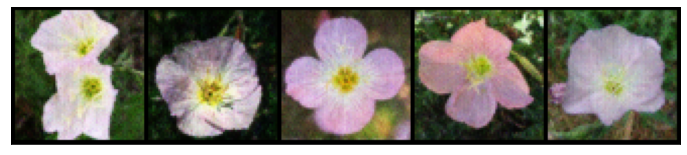

In [ ]:
pred_img = generator(latent_vectors_batched[3])
showImages(pred_img)

In [ ]:
pred_img.shape

torch.Size([5, 3, 64, 64])

In [ ]:
import math


class SRGenerator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(SRGenerator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class SRDiscriminator(nn.Module):
    def __init__(self):
        super(SRDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

#SRGAN - Low Res o/p of baseline as input

In [ ]:
srgenerator = SRGenerator(1)
srdiscriminator = SRDiscriminator()
srdiscriminator = to_device(srdiscriminator, device)
srgenerator = to_device(srgenerator, device)

In [ ]:
latent_vectors_batched = [to_device(lvb, device) for lvb in latent_vectors_batched]
print(latent_vectors_batched[1].device)

cuda:0


torch.Size([5, 3, 64, 64])


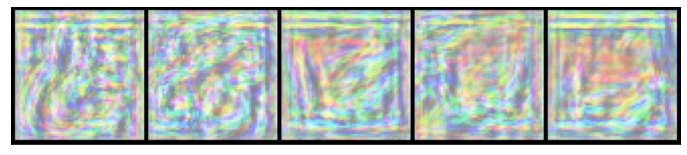

In [ ]:
fake_image = srgenerator(pred_img)
print(fake_image.shape)
showImages(fake_image)

In [ ]:
pred_img.shape

torch.Size([5, 3, 64, 64])

In [ ]:

pred_img.shape[0]

5

In [ ]:
latent_vectors_batched[0].shape

torch.Size([5, 100, 1, 1])

In [ ]:
fake_image[0]

tensor([[[ 4.3035e-03,  7.6568e-03,  2.0411e-03, -2.0424e-03],
         [-4.5420e-03,  7.0629e-03, -1.1316e-03,  4.1741e-03],
         [-3.3207e-03, -8.1925e-03,  1.1919e-03, -1.0009e-02],
         [-5.9032e-03, -1.7065e-02,  9.7203e-03,  1.1646e-03]],

        [[ 2.4902e-03,  1.9753e-02,  6.5730e-03,  4.5629e-03],
         [ 2.2121e-02,  8.6238e-03,  1.5612e-02, -1.4013e-04],
         [ 4.5550e-05,  1.3910e-02,  7.0372e-03,  3.6005e-03],
         [-2.2249e-03, -1.1829e-02,  1.7849e-02, -5.7760e-05]],

        [[-2.2104e-02,  5.0157e-03,  3.6182e-04, -3.4899e-03],
         [ 6.2994e-03, -1.3355e-02,  6.9120e-03, -9.5502e-03],
         [-1.9986e-02, -1.3150e-02, -9.3273e-03, -4.1955e-03],
         [-9.9990e-03, -8.1466e-03, -9.6279e-03, -3.5933e-03]],

        ...,

        [[ 2.3945e-03, -8.0556e-03, -1.4561e-03, -3.8197e-03],
         [-1.4086e-02,  1.7952e-02, -9.6568e-04,  1.6103e-02],
         [ 5.7042e-03, -1.2101e-02,  1.4537e-02, -4.7893e-03],
         [-8.2272e-04, -3.0106e-03,

In [ ]:
def train_srgenerator(gen_input, opt_g):
  opt_g.zero_grad()

  #Generate fake images from text description
  fake_images = srgenerator(gen_input)

  #Try to fool the discriminator
  preds = srdiscriminator(fake_images)
  targets = torch.ones(gen_input.size(0), 1, device=device)
  targets = targets.squeeze(1)

  loss = F.binary_cross_entropy(preds, targets)

  #Update generator weights
  loss.backward(retain_graph=True)
  opt_g.step()

  return loss.item()

In [ ]:
def train_srdiscriminator(real_image, gen_input, opt_d):
  opt_d.zero_grad()

  #Pass real Image through discriminator
  real_preds = srdiscriminator(real_image)
  real_targets = torch.ones(real_image.size(0), 1, device=device)
  real_targets = real_targets.squeeze(1)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #Generate fake images from text description
  fake_images = srgenerator(gen_input)

  #Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_targets = fake_targets.squeeze(1)
  fake_preds = srdiscriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward(retain_graph=True)
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    #Losses and Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(srdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(srgenerator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for i, (real_images, _) in tqdm(enumerate(train_dl)):
            # Train discriminator 

            loss_d, real_score, fake_score = train_srdiscriminator(real_image=real_images, gen_input=generator(latent_vectors_batched[i]) , opt_d=opt_d)
            loss_g = train_srgenerator(gen_input=generator(latent_vectors_batched[i]), opt_g=opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save Generated images
        #save_sample2(epoch+start_idx, latent_vectors_batched[i], show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 1e-4
epochs = 40

In [ ]:
history = fit(epochs, lr)

0it [00:00, ?it/s]

Epoch [1/40], loss_g: 0.9701, loss_d: 1.1903, real_score: 0.5515, fake_score: 0.4448


0it [00:00, ?it/s]

Epoch [2/40], loss_g: 0.9841, loss_d: 1.2108, real_score: 0.6236, fake_score: 0.5144


0it [00:00, ?it/s]

Epoch [3/40], loss_g: 1.3866, loss_d: 0.7274, real_score: 0.6896, fake_score: 0.2951


0it [00:00, ?it/s]

Epoch [4/40], loss_g: 1.5153, loss_d: 0.5222, real_score: 0.7773, fake_score: 0.2338


0it [00:00, ?it/s]

Epoch [5/40], loss_g: 1.9377, loss_d: 0.3683, real_score: 0.8389, fake_score: 0.1736


0it [00:00, ?it/s]

Epoch [6/40], loss_g: 2.1718, loss_d: 0.3231, real_score: 0.8930, fake_score: 0.1859


0it [00:00, ?it/s]

Epoch [7/40], loss_g: 1.9307, loss_d: 0.5701, real_score: 0.8843, fake_score: 0.3315


0it [00:00, ?it/s]

Epoch [8/40], loss_g: 2.7713, loss_d: 0.2466, real_score: 0.8729, fake_score: 0.1025


0it [00:00, ?it/s]

Epoch [9/40], loss_g: 2.9286, loss_d: 0.1199, real_score: 0.9506, fake_score: 0.0666


0it [00:00, ?it/s]

Epoch [10/40], loss_g: 3.1891, loss_d: 0.1043, real_score: 0.9561, fake_score: 0.0573


0it [00:00, ?it/s]

Epoch [11/40], loss_g: 3.3690, loss_d: 0.0713, real_score: 0.9664, fake_score: 0.0364


0it [00:00, ?it/s]

Epoch [12/40], loss_g: 3.4277, loss_d: 0.0668, real_score: 0.9741, fake_score: 0.0396


0it [00:00, ?it/s]

Epoch [13/40], loss_g: 3.7565, loss_d: 0.0488, real_score: 0.9785, fake_score: 0.0266


0it [00:00, ?it/s]

Epoch [14/40], loss_g: 3.8745, loss_d: 0.0411, real_score: 0.9817, fake_score: 0.0223


0it [00:00, ?it/s]

Epoch [15/40], loss_g: 4.0492, loss_d: 0.0339, real_score: 0.9849, fake_score: 0.0185


0it [00:00, ?it/s]

Epoch [16/40], loss_g: 4.1040, loss_d: 0.0322, real_score: 0.9870, fake_score: 0.0189


0it [00:00, ?it/s]

Epoch [17/40], loss_g: 4.2393, loss_d: 0.0304, real_score: 0.9885, fake_score: 0.0187


0it [00:00, ?it/s]

Epoch [18/40], loss_g: 4.4442, loss_d: 0.0243, real_score: 0.9890, fake_score: 0.0132


0it [00:00, ?it/s]

Epoch [19/40], loss_g: 4.4534, loss_d: 0.0221, real_score: 0.9907, fake_score: 0.0127


0it [00:00, ?it/s]

Epoch [20/40], loss_g: 4.6248, loss_d: 0.0202, real_score: 0.9916, fake_score: 0.0117


0it [00:00, ?it/s]

Epoch [21/40], loss_g: 4.7352, loss_d: 0.0173, real_score: 0.9924, fake_score: 0.0096


0it [00:00, ?it/s]

Epoch [22/40], loss_g: 4.8222, loss_d: 0.0162, real_score: 0.9932, fake_score: 0.0093


0it [00:00, ?it/s]

Epoch [23/40], loss_g: 4.9536, loss_d: 0.0140, real_score: 0.9937, fake_score: 0.0077


0it [00:00, ?it/s]

Epoch [24/40], loss_g: 4.8993, loss_d: 0.0150, real_score: 0.9943, fake_score: 0.0092


0it [00:00, ?it/s]

Epoch [25/40], loss_g: 5.1324, loss_d: 0.0126, real_score: 0.9947, fake_score: 0.0073


0it [00:00, ?it/s]

Epoch [26/40], loss_g: 5.2595, loss_d: 0.0105, real_score: 0.9950, fake_score: 0.0055


0it [00:00, ?it/s]

Epoch [27/40], loss_g: 5.3072, loss_d: 0.0101, real_score: 0.9954, fake_score: 0.0055


0it [00:00, ?it/s]

Epoch [28/40], loss_g: 5.4298, loss_d: 0.0093, real_score: 0.9957, fake_score: 0.0050


0it [00:00, ?it/s]

Epoch [29/40], loss_g: 5.3828, loss_d: 0.0094, real_score: 0.9961, fake_score: 0.0055


0it [00:00, ?it/s]

Epoch [30/40], loss_g: 5.4901, loss_d: 0.0084, real_score: 0.9963, fake_score: 0.0047


0it [00:00, ?it/s]

Epoch [31/40], loss_g: 5.4886, loss_d: 0.0082, real_score: 0.9966, fake_score: 0.0048


0it [00:00, ?it/s]

Epoch [32/40], loss_g: 5.5612, loss_d: 0.0077, real_score: 0.9967, fake_score: 0.0044


0it [00:00, ?it/s]

Epoch [33/40], loss_g: 5.6362, loss_d: 0.0078, real_score: 0.9969, fake_score: 0.0047


0it [00:00, ?it/s]

Epoch [34/40], loss_g: 5.7619, loss_d: 0.0066, real_score: 0.9971, fake_score: 0.0037


0it [00:00, ?it/s]

Epoch [35/40], loss_g: 5.6360, loss_d: 0.0076, real_score: 0.9972, fake_score: 0.0048


0it [00:00, ?it/s]

Epoch [36/40], loss_g: 5.8665, loss_d: 0.0057, real_score: 0.9974, fake_score: 0.0031


0it [00:00, ?it/s]

Epoch [37/40], loss_g: 5.8664, loss_d: 0.0056, real_score: 0.9976, fake_score: 0.0032


0it [00:00, ?it/s]

Epoch [38/40], loss_g: 5.8845, loss_d: 0.0056, real_score: 0.9978, fake_score: 0.0033


0it [00:00, ?it/s]

Epoch [39/40], loss_g: 6.0123, loss_d: 0.0048, real_score: 0.9979, fake_score: 0.0027


0it [00:00, ?it/s]

Epoch [40/40], loss_g: 6.0379, loss_d: 0.0047, real_score: 0.9980, fake_score: 0.0027


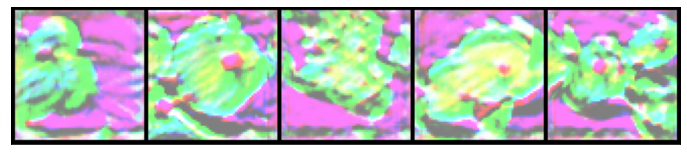

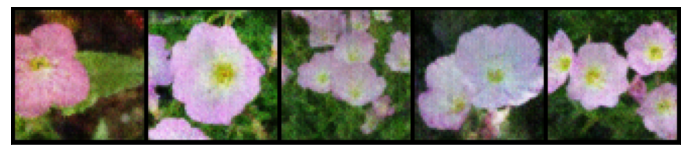

In [ ]:

idx = 1
pred_img = srgenerator(generator(latent_vectors_batched[idx]))
showImages(pred_img)
showImages(generator(latent_vectors_batched[idx]))

In [ ]:
from torchvision.models import vgg19


class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval()
        self.vgg = to_device(self.vgg,device)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)


In [ ]:

torch.backends.cudnn.benchmark = True


def train_fn(disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):

    for idx, (real_image, _) in enumerate(train_dl):
        high_res = to_device(real_image,device)
        low_res =  to_device(generator(latent_vectors_batched[idx]),device)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = srgenerator(low_res)
        p = T.Compose([T.Scale((64,64))])
        disc_real = srdiscriminator(high_res)
        disc_fake = srdiscriminator(fake.detach())
        disc_loss_real = bce(
            disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)
        )
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        loss_disc.backward(retain_graph=True)

        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = srdiscriminator(fake)
        #l2_loss = mse(fake, high_res)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(p(fake), high_res)
        gen_loss = loss_for_vgg + adversarial_loss
        #print("Gen loss"+str(gen_loss))
        opt_gen.zero_grad()
        gen_loss.backward(retain_graph=True)
        opt_gen.step()

        # if idx % 200 == 0:
        #     plot_examples("test_images/", gen)
    return (gen_loss,loss_disc)



In [ ]:

gen = srgenerator
disc = srdiscriminator
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=1e-4, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = VGGLoss()

for epoch in range(30):
  metadatum = train_fn(disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
  print('Epoch'+str(epoch))
  print(metadatum)
  #save_sample2(epoch+0, latent_vectors_batched[i], show=False)
  


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Epoch0
(tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1137, device='cuda:0', grad_fn=<AddBackward0>))
Epoch1
(tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1139, device='cuda:0', grad_fn=<AddBackward0>))
Epoch2
(tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1039, device='cuda:0', grad_fn=<AddBackward0>))
Epoch3
(tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1212, device='cuda:0', grad_fn=<AddBackward0>))
Epoch4
(tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1251, device='cuda:0', grad_fn=<AddBackward0>))
Epoch5
(tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1013, device='cuda:0', grad_fn=<AddBackward0>))
Epoch6
(tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1255, device='cuda:0', grad_fn=<AddBackward0>))
Epoch7
(tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.0977, device='cuda:0', grad_fn=<AddBackward0>))
Epoch8
(tensor(0.0011, d

In [ ]:
for idx, (low_res, high_res) in enumerate(train_dl):
  print(idx)
  print(low_res.shape)
  print(generator(latent_vectors_batched[idx]).shape)
  print(vgg_loss(generator(latent_vectors_batched[idx]),low_res))
  break

0
torch.Size([5, 3, 64, 64])
torch.Size([5, 3, 64, 64])
tensor(0.3783, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
train_fn(disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([5, 512, 4, 4])) that is different to the input size (torch.Size([5, 512, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored